# Introduction to crispy

This software is designed to simulate lenslet array-based Integral Field Spectrographs and their reduction process. This was developed within the context of NASA's WFIRST Coronagraph mission.

In this notebook we go straight to the point and illustrate how to use the code. We require astropy, numpy. This notebook was written in a Python 3.5 kernel but should be backward compatible with Python 2.7.

## Create a polychromatic flatfield

### Initialization

First we need to load the various modules that we need. Since the notebook can be located anywhere, we need to add the location of the Python code to the path first.

In [1]:
import sys
codefolder = '../../../../crispy'
if codefolder not in sys.path: sys.path.append(codefolder)
import numpy as np
from crispy.tools.initLogger import getLogger
log = getLogger('crispy')

All the IFS parameters are contained within a Python class called 'Params'. This class is initialized using only the path the 'code' directory from the repo. In particular, the Params class stores all the relevant paths. All parameters can be changed on the fly.

In [2]:
from crispy.params import Params
codefolder = '../../../crispy'
par = Params(codefolder)

All the parameters are stored in this class. During the various steps of the software, they are appended to a header file.

In [3]:
par.hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT                                                                         
COMMENT ************************************************************            
COMMENT ********************** General parameters ******************            
COMMENT ************************************************************            
COMMENT                                                                         
NLENS   =                  108 / # lenslets across array                        
PITCH   =             0.000174 / Lenslet pitch (meters)                         
INTERLAC=                    2 / Interlacing                                    
PHILENS =    26.565051177077

### Create the flatfield

Creating a flatfield is a function built into the unitTests module. In this case, we will construct a cube of nlam wavelength slices, each having 512x512 pixels of value 1. The standard 

In [4]:
from crispy.unitTests import testCreateFlatfield
help(testCreateFlatfield)

Help on function testCreateFlatfield in module crispy.unitTests:

testCreateFlatfield(par, pixsize=0.1, npix=512, pixval=1.0, Nspec=45, outname='flatfield.fits', useQE=False, method='optext')
    Creates a polychromatic flatfield
    
    Parameters
    ----------
    par :   Parameter instance
        Contains all IFS parameters
    pixsize:   float
       Pixel scale (lam/D)
    npix: int
        Each input frame has a pixel size npix x npix
    pixval: float
        Each input frame has a unform value pixval in photons per second per nm of bandwidth
    Nspec: float
        Optional input forcing the number of wavelengths bins used
    outname: string
        Name of flatfield image
    useQE: boolean 
        Whether to take into account the wavelength-dependent QE of the detector



This test function will create a polychromatic flatfield at the wavelengths provided by the existing wavelength calibration. Those wavelengths can be retrieved as follows.

In [5]:
from crispy.tools.reduction import calculateWaveList
help(calculateWaveList)
lam_midpts,lam_endpts = calculateWaveList(par)
print(lam_midpts)

Help on function calculateWaveList in module crispy.tools.reduction:

calculateWaveList(par, lam_list=None, Nspec=None, method='lstsq')
    Computes the wavelength lists corresponding to the center and endpoints of each
    spectral bin. Wavelengths are separated by a constant value in log space. Number of
    wavelengths depends on spectral resolution.
    
    Parameters
    ----------
    par:        Parameter instance
            Contains all IFS parameters
    lam_list:   list of floats
            Usually this is left to None. If so, we use the wavelengths used for wavelength
            calibration. Otherwise, we could decide to focus on a smaller/larger region of
            the spectrum to retrieve. The final processed cubes will have bins centered
            on lam_midpts
    Nspec: int
            If specified, forces the number of bins in the final cube (uses np.linspace)
              
    Returns
    -------
    lam_midpts: list of floats
            Wavelengths at the m

Now let's create our flatfield. By default it will be stored as par.unitTestsOutput/flatfield.fits

In [6]:
testCreateFlatfield(par,useQE=True)

crispy - INFO - Reduced cube will have 44 wavelength bins
crispy - INFO - The number of input pixels per lenslet is 5.000000
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming endpoints wavelist is given
crispy - INFO - Done.
crispy - INFO - Performance: 36 seconds total
crispy - INFO - Writing data to ../../../crispy/unitTestsOutputs/flatfield.fits


In [7]:
par.hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT                                                                         
COMMENT ************************************************************            
COMMENT ********************** General parameters ******************            
COMMENT ************************************************************            
COMMENT                                                                         
NLENS   =                  108 / # lenslets across array                        
PITCH   =             0.000174 / Lenslet pitch (meters)                         
INTERLAC=                    2 / Interlacing                                    
PHILENS =    26.565051177077

### Display results

Depending on your version of Python you might see a bunch of VisibleDeprecationWarning. We are working on fixing that. Let's see what we got.

In [8]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'

Populating the interactive namespace from numpy and matplotlib


crispy - INFO - Read data from HDU 1 of ../../../crispy/unitTestsOutputs/flatfield.fits


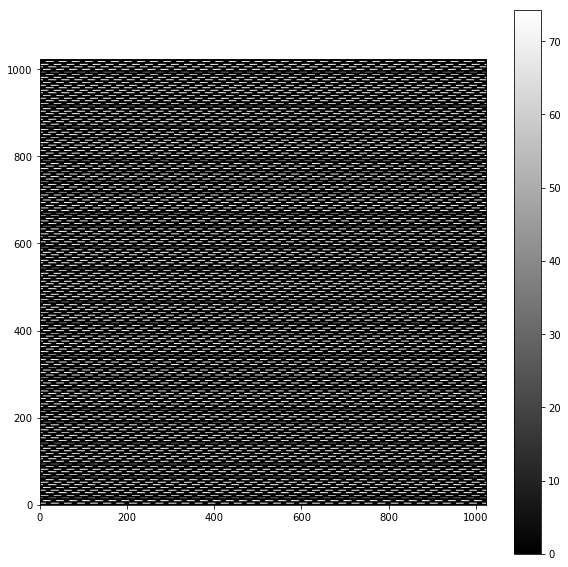

In [9]:
from crispy.tools.image import Image
plt.figure(figsize=(10,10))
plt.imshow(Image(par.unitTestsOutputs+'/flatfield.fits').data,cmap='gray')
plt.colorbar()

A zoom-in version is visible here:

crispy - INFO - Read data from HDU 1 of ../../../crispy/unitTestsOutputs/flatfield.fits


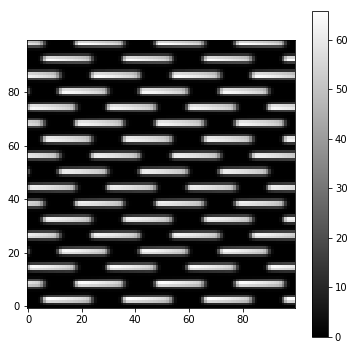

In [10]:
plt.figure(figsize=(6,6))
img = Image(par.unitTestsOutputs+'/flatfield.fits').data
subsize = 50
plt.imshow(img[par.npix//2-subsize:par.npix//2+subsize,par.npix//2-subsize:par.npix//2+subsize],cmap='gray')
plt.colorbar()

## Simulate detector readout

We have also some routines that can add noise to the detector. Assuming that the input detector map is in photons per second, we can 'detectorify' this map by adding Poisson noise, read noise, CIC noise, and dark current noise. In the future, we will also implement Electron-multiplying noise and Traps.

In [11]:
from crispy.tools.image import Image
from crispy.tools.detector import readDetector,averageDetectorReadout
flat = Image(filename=par.unitTestsOutputs+'/flatfield.fits')
# turn off photon counting otherwise things are strange
par.EMStats =False # turn off EM register statistics
par.PCmode = False # turn off photon counting threshold
read=readDetector(par,flat,inttime=100)


crispy - INFO - Read data from HDU 1 of ../../../crispy/unitTestsOutputs/flatfield.fits


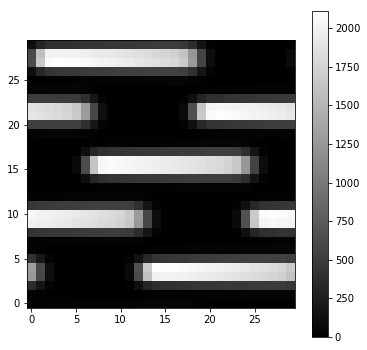

In [12]:
plt.figure(figsize=(6,6))
subsize = 15

plt.imshow(read[par.npix//2-subsize:par.npix//2+subsize,par.npix//2-subsize:par.npix//2+subsize],cmap='gray')
plt.colorbar()

Let's save the noisified frame to a new name. This is useful to show since writing to FITS is a very common task.

In [13]:
newImage = Image(data=read,header=par.hdr)
newImage.write(par.unitTestsOutputs+'/flatfield_noise.fits',clobber=True)


crispy - INFO - Writing data to ../../../crispy/unitTestsOutputs/flatfield_noise.fits


## Reduction step

The reduction step is straightforward, as long as the wavelength calibration is good.

In [14]:
from crispy.IFS import reduceIFSMap
cube = reduceIFSMap(par,par.unitTestsOutputs+'/flatfield_noise.fits')


crispy - INFO - Read data from HDU 1 of ../../../crispy/unitTestsOutputs/flatfield_noise.fits
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Writing data to ../../../crispy/SimResults/flatfield_noise_red_optext.fits
crispy - INFO - Elapsed time: 1.507257s


Now we can display the cube interactively, or look it up with DS9 (it is located in par.exportDir)

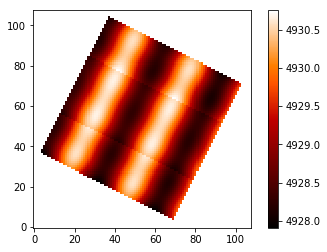

In [15]:
import ipywidgets
def plt_ifs_optext(wchan):
    plt.imshow(cube.data[wchan-1,:,:],
                cmap='gist_heat')
    plt.colorbar()
ipywidgets.interact(plt_ifs_optext, wchan=(1,cube.data.shape[0]));


Let's look now at the header of the created file

In [16]:
cube.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT                                                                         
COMMENT ************************************************************            
COMMENT ********************** General parameters ******************            
COMMENT ************************************************************            
COMMENT                                                                         
NLENS   =                  108 / # lenslets across array                        
PITCH   =             0.000174 / Lenslet pitch (meters)                         
INTERLAC=                    2 / Interlacing                                    
PHILENS =    26.565051177077

# Process cubes from John Krist

In [17]:
# cleans the header
par.makeHeader()
par.hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT                                                                         
COMMENT ************************************************************            
COMMENT ********************** General parameters ******************            
COMMENT ************************************************************            
COMMENT                                                                         
NLENS   =                  108 / # lenslets across array                        
PITCH   =             0.000174 / Lenslet pitch (meters)                         
INTERLAC=                    2 / Interlacing                                    
PHILENS =    26.565051177077

In [18]:
# example of John Krist cube
offaxispsf= '/Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits'
offaxis = Image(offaxispsf)
offaxis.header

crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits


SIMPLE  =                    T / Written by IDL:  Tue Feb 21 14:04:33 2017      
BITPIX  =                  -64 / Number of bits per data pixel                  
NAXIS   =                    3 / Number of data axes                            
NAXIS1  =                  256 /Number of positions along axis 1                
NAXIS2  =                  256 /Number of positions along axis 2                
NAXIS3  =                   45 /Number of positions along axis 3                
DATE    = '2017-02-17'         / Creation UTC (CCCC-MM-DD) date of FITS header  
NLAM    =                   45 / Number of wavelengths                          
LAM_C   =             0.800000 / Passband central wavelength in microns         
LAM_MIN =       0.728000000000 / Minimum passband wavelength                    
LAM_MAX =       0.872000000000 / Maximum passband wavelength                    
PIXSIZE =             0.100000 / sampling in lam_c/D radians                    
OFFSET  =              7.000

Shift the cube to the correct wavelength range corresponding to the band. We assume that the PSF doesn't change, we just change the header keywords.

In [19]:
from crispy.tools.inputScene import adjust_krist_header
adjust_krist_header(offaxis,lamc=660.)
offaxis.header

SIMPLE  =                    T / Written by IDL:  Tue Feb 21 14:04:33 2017      
BITPIX  =                  -64 / Number of bits per data pixel                  
NAXIS   =                    3 / Number of data axes                            
NAXIS1  =                  256 /Number of positions along axis 1                
NAXIS2  =                  256 /Number of positions along axis 2                
NAXIS3  =                   45 /Number of positions along axis 3                
DATE    = '2017-02-17'         / Creation UTC (CCCC-MM-DD) date of FITS header  
NLAM    =                   45 / Number of wavelengths                          
LAM_C   =                 0.66 / Passband central wavelength in microns         
LAM_MIN =   0.6005999999999999 / Minimum passband wavelength                    
LAM_MAX =   0.7193999999999999 / Maximum passband wavelength                    
PIXSIZE =             0.100000 / sampling in lam_c/D radians                    
OFFSET  =              7.000

### Process the cube

In [20]:
par.saveDetector=False
lamlist = np.linspace(offaxis.header['LAM_MIN'],offaxis.header['LAM_MAX'],offaxis.header['NLAM'])*1000
print(lamlist)

from crispy.IFS import polychromeIFS
detectorFrame = polychromeIFS(par,lamlist,offaxis,QE=True)

# save
Image(data=detectorFrame,header=par.hdr).write(par.exportDir+'/test_krist_cube.fits')

[ 600.6  603.3  606.   608.7  611.4  614.1  616.8  619.5  622.2  624.9
  627.6  630.3  633.   635.7  638.4  641.1  643.8  646.5  649.2  651.9
  654.6  657.3  660.   662.7  665.4  668.1  670.8  673.5  676.2  678.9
  681.6  684.3  687.   689.7  692.4  695.1  697.8  700.5  703.2  705.9
  708.6  711.3  714.   716.7  719.4]
crispy - INFO - The number of input pixels per lenslet is 5.000000
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Done.
crispy - INFO - Performance: 27 seconds total
crispy - INFO - Writing data to ../../../crispy/SimResults/test_krist_cube.fits


### Reduce the cube

In [21]:
reduced = reduceIFSMap(par,par.exportDir+'/test_krist_cube.fits')

crispy - INFO - Read data from HDU 1 of ../../../crispy/SimResults/test_krist_cube.fits
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Writing data to ../../../crispy/SimResults/test_krist_cube_red_optext.fits
crispy - INFO - Elapsed time: 1.286819s


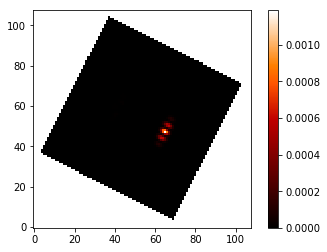

In [22]:
def plt_ifs_optext(wchan):
    plt.imshow(reduced.data[wchan-1,:,:],
                cmap='gist_heat')
    plt.colorbar()
ipywidgets.interact(plt_ifs_optext, wchan=(1,reduced.data.shape[0]));
